In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import json

from shapely.geometry import box
from shapely.affinity import rotate
import geopandas as gpd

from grid_and_bathy import build_grid, get_grid_angle
from configs.config_object import ConfigObject

In [2]:
config = ConfigObject('../config.json')

In [3]:
grid_resolution_ini=config.grid_resolution
nx_ini=config.Nx; ny_ini=config.Ny  #Ny initially set to 120

# point of origin
x0_crs_init = config.x0
y0_crs_ini = config.y0

# second point for tilted grid
x1_crs_ini = config.x1
y1_crs_ini = config.y1

In [4]:
xy_land = np.loadtxt(config.paths.shoreline_path)
output_folder = config.paths.grid_folder_path

In [5]:
def plot_grid(x_arr: np.array, y_arr: np.array):
    for i_row in range(x_arr.shape[0]):
        for i_column in range(x_arr.shape[1]):
            x_col = [x_arr[i_row, i_column], x_arr[i_row-1, i_column]]
            y_col = [y_arr[i_row, i_column], y_arr[i_row-1, i_column]]
            plt.plot(x_col, y_col, 'k-', lw=1, color='darkred')  # Draw columns
            
            x_line = [x_arr[i_row, i_column], x_arr[i_row, i_column-1]]
            y_line = [y_arr[i_row, i_column], y_arr[i_row, i_column-1]]
            plt.plot(x_line, y_line, lw=1, color='darkred')  # Draw columns

# Creating grid

In [6]:
factor = 1
grid_resolution = grid_resolution_ini * factor
nx = nx_ini / factor
ny = ny_ini / factor

# Coordinates at cell center instead of corner
x0_c = x0_crs_init + grid_resolution / 2
y0_c = y0_crs_ini + grid_resolution / 2
x1_c = x1_crs_ini + grid_resolution / 2
y1_c = y1_crs_ini + grid_resolution / 2

rot_angle = get_grid_angle(x0_crs_init, y0_crs_ini, x1_crs_ini, y1_crs_ini)
rot_angle_in_degrees = np.degrees(rot_angle)

x, y, xc_rotated, yc_rotated, lat_grid, lon_grid = build_grid(nx, ny, grid_resolution, grid_resolution, x0_c, y0_c, x1_c, y1_c, crs_ini=config.epsg_projection, crs_target="4326")

In [8]:
rot_angle_in_degrees

np.float64(19.411486858683578)

# Simple plot

In [8]:
x_corner_to_center = np.cos(rot_angle) * grid_resolution/2 - np.sin(rot_angle) * grid_resolution/2
y_corner_to_center = np.sin(rot_angle) * grid_resolution/2 + np.cos(rot_angle) * grid_resolution/2

plt.close('all')
plt.figure(figsize=(12,7))
plt.scatter(xc_rotated.flatten(), yc_rotated.flatten())
plot_grid(xc_rotated - x_corner_to_center, yc_rotated - y_corner_to_center) # last row/column are missing because xc_rotated are given for the center of the cells, not the border
plt.plot(xy_land[:,0], xy_land[:,1], color='black', zorder=2)
plt.show()

# Display core allocation

In [9]:
Px = config.Px
Py = config.Py

x_res_cores = nx * grid_resolution / Px
y_res_cores = ny * grid_resolution / Py

print(f'Px: {Px}, Py: {Py}, x_res_cores: {x_res_cores}, y_res_cores: {y_res_cores}')

x_cores, y_cores, x_rotated_cores, y_rotated_cores, lat_grid_cores, lon_grid_cores = build_grid(Px + 1, Py + 1, x_res_cores, y_res_cores, x0_crs_init, y0_crs_ini, x1_crs_ini, y1_crs_ini, crs_ini=config.epsg_projection, crs_target="4326")

Px: 48, Py: 12, x_res_cores: 1400.0, y_res_cores: 2200.0


C:\Users\leroquan\AppData\Local\Temp\ipykernel_28648\2844172201.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_col, y_col, 'k-', lw=1, color='darkred')  # Draw columns


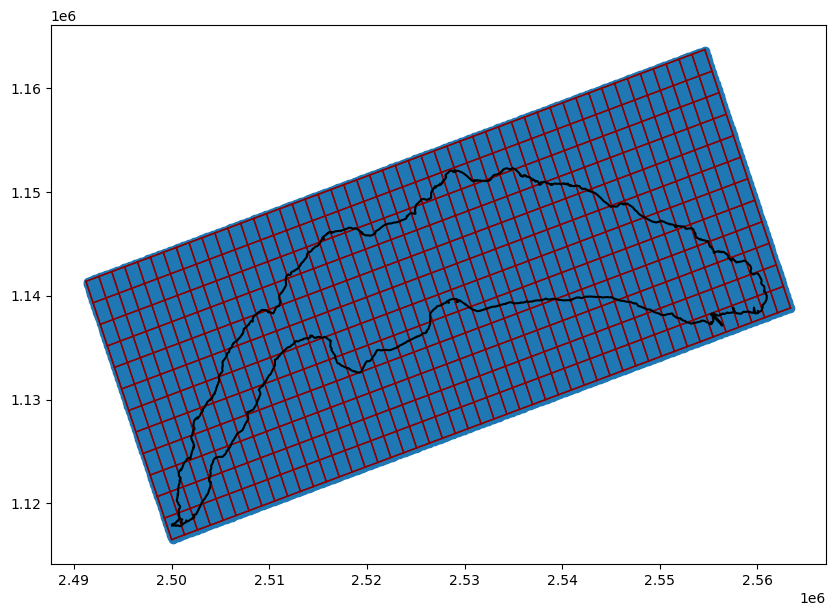

In [10]:
plt.close('all')
plt.figure(figsize=(10,7))
plt.scatter(xc_rotated.flatten(), yc_rotated.flatten())
plot_grid(x_rotated_cores, y_rotated_cores)
plt.plot(xy_land[:,0], xy_land[:,1], color='black', zorder=2)
plt.show()

## Create polygons of the MITgcm grid

In [18]:
geoms = []
half = grid_resolution / 2

for i in range(len(xc_rotated.flatten())):
        # Create square centered at (x, y)
        xc, yc = xc_rotated.flatten()[i], yc_rotated.flatten()[i]
        cell = box(xc - half, yc - half, xc + half, yc + half)
        rotated = rotate(cell, rot_angle_in_degrees, origin='centroid')
        geoms.append(rotated)

grid = gpd.GeoDataFrame(geometry=geoms, crs=f'EPSG:{config.epsg_projection}')

# Create parameters file

In [9]:
grid_parameters ={
    "resolution": grid_resolution,
    "buffer": 0.02,
    "Nx": nx,
    "Ny": ny,
    "rotation": rot_angle_in_degrees
}


# Save grid

In [19]:
with open(os.path.join(output_folder, 'x.npy'), 'wb') as f:
    np.save(f, x)

with open(os.path.join(output_folder, 'y.npy'), 'wb') as f:
    np.save(f, y)

with open(os.path.join(output_folder, f'x_epsg{config.epsg_projection}_grid.npy'), 'wb') as f:
    np.save(f, xc_rotated)

with open(os.path.join(output_folder, f'y_epsg{config.epsg_projection}_grid.npy'), 'wb') as f:
    np.save(f, yc_rotated)

with open(os.path.join(output_folder, 'lat_grid.npy'), 'wb') as f:
    np.save(f, lat_grid)

with open(os.path.join(output_folder, 'lon_grid.npy'), 'wb') as f:
    np.save(f, lon_grid)

In [20]:
grid.to_file(os.path.join(output_folder, f"grid_epsg{config.epsg_projection}.gpkg"), driver="GPKG")

In [10]:
# Save dictionary as JSON
with open(os.path.join(output_folder, "parameters.json"), "w") as f:
    json.dump(grid_parameters, f, indent=4)  # indent for pretty-printing